# Analiza wydajności metod mnożenia macierzy

1. Naiwna metoda (potrójne pętle w naturalnej kolejności)
2. Ulepszona metoda (ze zamienioną kolejnością pętli)
3. Implementacja z użyciem BLAS (poprzez GSL)
+ porównanie wydajności optymalizacji

In [1]:
using DataFrames
using CSV
using Plots
using Statistics
using Printf
using Polynomials: fit, coeffs

## Wczytanie danych z pliku CSV

Najpierw wczytamy dane wygenerowane przez program w C:

In [2]:
# Wczytanie danych
df_no_opt = CSV.read("results_no_opt.csv", DataFrame)
println("Dane bez optymalizacji:")
df_no_opt

Dane bez optymalizacji:


Row,Rozmiar,Naiwna,Ulepszona,BLAS
,Int64,Float64,Float64,Float64
1,100,0.003767,0.002119,0.00042
2,200,0.02783,0.015892,0.003175
3,300,0.093196,0.055949,0.010685
4,400,0.222499,0.130524,0.025379
5,500,0.439732,0.267648,0.064738
6,600,0.760169,0.478575,0.110445
7,700,1.30135,0.765503,0.156611
8,800,1.82946,1.59432,0.245967
9,900,2.6321,1.66288,0.393837


In [3]:

df_opt = CSV.read("results_opt.csv", DataFrame)
println("Dane z optymalizacją:")
df_opt

Dane z optymalizacją:


Row,Rozmiar,Naiwna,Ulepszona,BLAS
,Int64,Float64,Float64,Float64
1,100,0.000951,0.000492,0.000455
2,200,0.00732,0.003422,0.00362
3,300,0.026552,0.009516,0.00995
4,400,0.065702,0.026594,0.026249
5,500,0.134627,0.059845,0.059391
6,600,0.239504,0.111017,0.104934
7,700,0.389711,0.193764,0.170102
8,800,0.600157,0.889076,0.303193
9,900,0.879645,0.442465,0.368705


## Wizualizacja wyników bez optymalizacji kompilatora

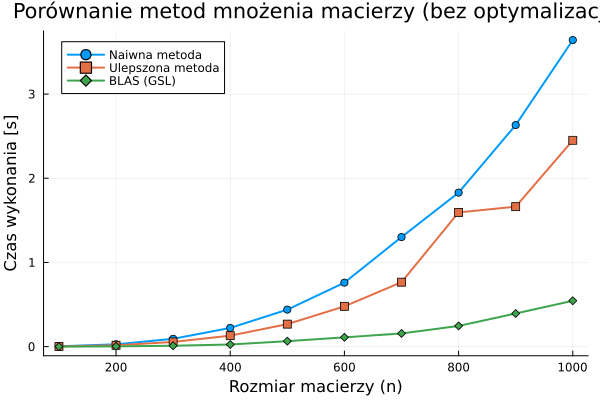

In [4]:
p1 = plot(df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Naiwna metoda", 
    xlabel="Rozmiar macierzy (n)", 
    ylabel="Czas wykonania [s]",
    title="Porównanie metod mnożenia macierzy (bez optymalizacji)",
    lw=2, marker=:circle, markersize=4)

plot!(p1, df_no_opt.Rozmiar, df_no_opt.Ulepszona, 
    label="Ulepszona metoda", 
    lw=2, marker=:square, markersize=4)

plot!(p1, df_no_opt.Rozmiar, df_no_opt.BLAS, 
    label="BLAS (GSL)", 
    lw=2, marker=:diamond, markersize=4)

display(p1)

## Analiza przyspieszenia względem naiwnej metody

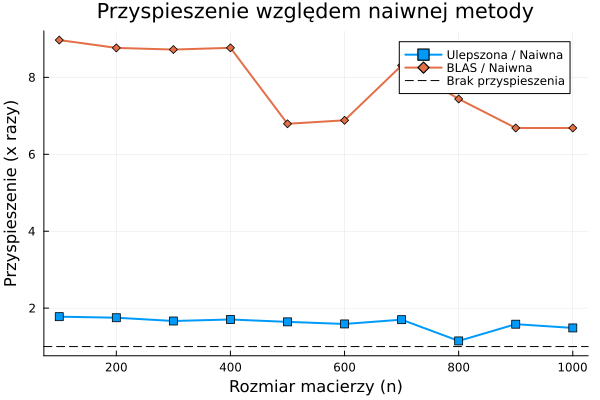

In [5]:
df_no_opt[!, :Przyspieszenie_Ulepszona] = df_no_opt.Naiwna ./ df_no_opt.Ulepszona
df_no_opt[!, :Przyspieszenie_BLAS] = df_no_opt.Naiwna ./ df_no_opt.BLAS

p2 = plot(df_no_opt.Rozmiar, df_no_opt.Przyspieszenie_Ulepszona, 
    label="Ulepszona / Naiwna", 
    xlabel="Rozmiar macierzy (n)", 
    ylabel="Przyspieszenie (x razy)",
    title="Przyspieszenie względem naiwnej metody",
    lw=2, marker=:square, markersize=4)

plot!(p2, df_no_opt.Rozmiar, df_no_opt.Przyspieszenie_BLAS, 
    label="BLAS / Naiwna", 
    lw=2, marker=:diamond, markersize=4)

hline!(p2, [1.0], label="Brak przyspieszenia", ls=:dash, color=:black)

display(p2)

## Aproksymacja wielomianowa

Teoretyczna złożoność mnożenia macierzy to O(n³) więc używam wielomianu trzeciego stopnia.

In [17]:
# Funkcja pomocnicza do dopasowania wielomianu stopnia 3
using Pkg
Pkg.add("Polynomials")
Pkg.add("TaylorSeries")
using Polynomials
using TaylorSeries
function fit_and_plot_polynomial(x, y, label_data, color, title_suffix="")
    # Dopasowanie wielomianu stopnia 3 (zgodnie z teoretyczną złożonością O(n³))
    poly_fit = fit(x, y, 3)
    
    # Współczynniki wielomianu
    coeffs = Polynomials.coeffs(poly_fit)
    
    # Przygotowanie równania wielomianu do wyświetlenia
    equation = @sprintf("%.2e·n³ + %.2e·n² + %.2e·n + %.2e", coeffs[4], coeffs[3], coeffs[2], coeffs[1])
    
    println("$label_data aproksymacja: $equation")
    
    # Generowanie punktów dla gładkiego wykresu wielomianu
    x_smooth = range(minimum(x), maximum(x), length=100)
    y_smooth = [poly_fit(xi) for xi in x_smooth]
    
    # Rysowanie wykresu
    plot(x_smooth, y_smooth, 
         label="Wielomian dla $label_data", 
         color=color, 
         linewidth=2, 
         linestyle=:dash,
         title="Aproksymacja wielomianowa $title_suffix")
    
    # Dodanie punktów danych
    scatter!(x, y, 
             label="Dane $label_data", 
             color=color, 
             markersize=5)
    
    return poly_fit
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


fit_and_plot_polynomial (generic function with 2 methods)

Naiwna aproksymacja: 3.55e-09·n³ + 1.67e-07·n² + -9.31e-05·n + 8.61e-03


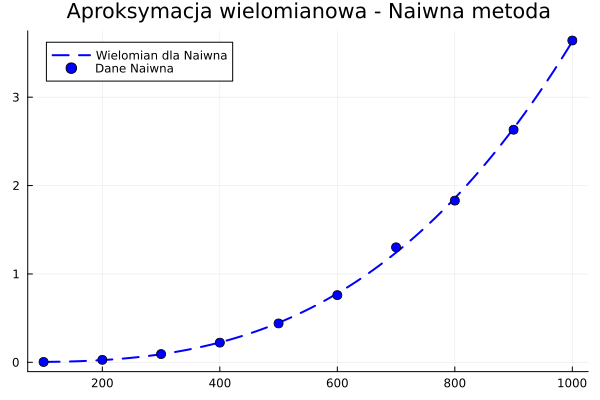

In [18]:
using Printf

# Aproksymacja dla naiwnej metody
poly_naive = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.Naiwna, 
    "Naiwna", 
    :blue,
    "- Naiwna metoda"
)

display(current())

Ulepszona aproksymacja: 7.25e-10·n³ + 2.88e-06·n² + -1.30e-03·n + 1.30e-01


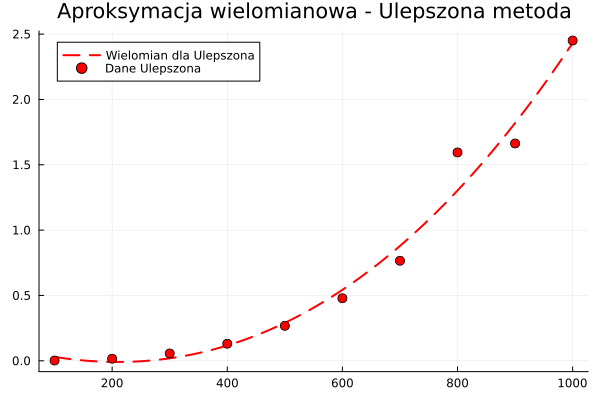

In [19]:
# Aproksymacja dla ulepszonej metody
poly_better = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.Ulepszona, 
    "Ulepszona", 
    :red,
    "- Ulepszona metoda"
)

display(current())

BLAS aproksymacja: 8.84e-10·n³ + -4.87e-07·n² + 1.65e-04·n + -1.50e-02


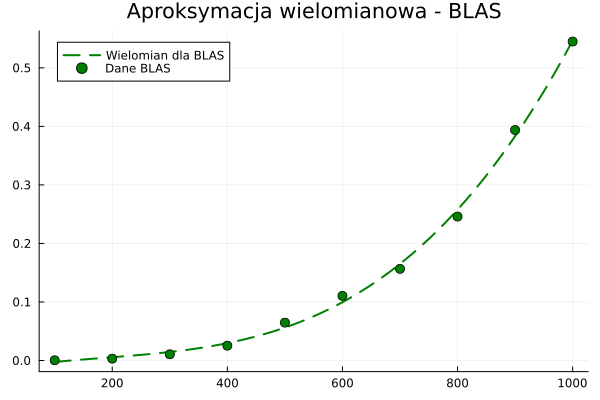

In [20]:
# Aproksymacja dla metody BLAS
poly_blas = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.BLAS, 
    "BLAS", 
    :green,
    "- BLAS"
)

display(current())

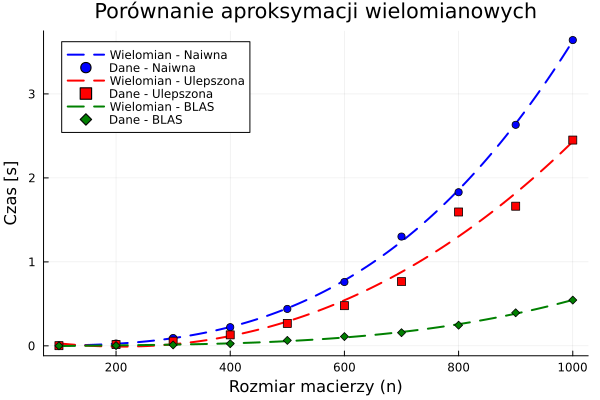

In [21]:
# Wykres zawierający wszystkie aproksymacje i dane dla lepszego porównania
p_all = plot(title="Porównanie aproksymacji wielomianowych", xlabel="Rozmiar macierzy (n)", ylabel="Czas [s]")

# Gładkie krzywe wielomianów
x_smooth = range(minimum(df_no_opt.Rozmiar), maximum(df_no_opt.Rozmiar), length=100)

# Naiwna metoda
plot!(p_all, x_smooth, [poly_naive(xi) for xi in x_smooth], 
    label="Wielomian - Naiwna", color=:blue, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Dane - Naiwna", color=:blue, marker=:circle, markersize=4)

# Ulepszona metoda
plot!(p_all, x_smooth, [poly_better(xi) for xi in x_smooth], 
    label="Wielomian - Ulepszona", color=:red, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.Ulepszona, 
    label="Dane - Ulepszona", color=:red, marker=:square, markersize=4)

# Metoda BLAS
plot!(p_all, x_smooth, [poly_blas(xi) for xi in x_smooth], 
    label="Wielomian - BLAS", color=:green, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.BLAS, 
    label="Dane - BLAS", color=:green, marker=:diamond, markersize=4)

display(p_all)

## Analiza współczynników wielomianu

Teoretyczna złożoność mnożenia macierzy to O(n³).

In [22]:
# Pobranie współczynników wielomianów
coeffs_naive = coeffs(poly_naive)
coeffs_better = coeffs(poly_better)
coeffs_blas = coeffs(poly_blas)

# Współczynnik przy n³ (czwarty współczynnik, indeks 4)
n3_naive = coeffs_naive[4]
n3_better = coeffs_better[4]
n3_blas = coeffs_blas[4]

println("Współczynniki przy n³:")
println("Naiwna metoda: $(n3_naive)")
println("Ulepszona metoda: $(n3_better)")
println("BLAS: $(n3_blas)")
println()
println("Przyspieszenie względem naiwnej metody (na podstawie współczynnika):")
println("Ulepszona / Naiwna: $(n3_naive / n3_better)")
println("BLAS / Naiwna: $(n3_naive / n3_blas)")

Współczynniki przy n³:
Naiwna metoda: 3.5481179098679124e-9
Ulepszona metoda: 7.248236208236228e-10
BLAS: 8.83583916083916e-10

Przyspieszenie względem naiwnej metody (na podstawie współczynnika):
Ulepszona / Naiwna: 4.895146636965498
BLAS / Naiwna: 4.015598117260137


## Porównanie z optymalizacją kompilatora (dla chętnych)

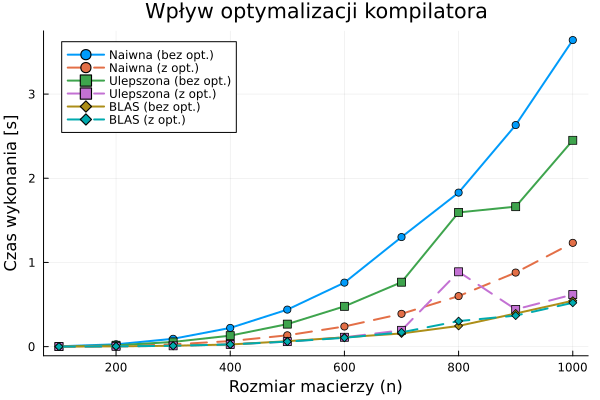

In [23]:
p3 = plot(title="Wpływ optymalizacji kompilatora", xlabel="Rozmiar macierzy (n)", ylabel="Czas wykonania [s]")

# Naiwna metoda
plot!(p3, df_no_opt.Rozmiar, df_no_opt.Naiwna, label="Naiwna (bez opt.)", lw=2, marker=:circle, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.Naiwna, label="Naiwna (z opt.)", lw=2, ls=:dash, marker=:circle, markersize=4)

# Ulepszona metoda
plot!(p3, df_no_opt.Rozmiar, df_no_opt.Ulepszona, label="Ulepszona (bez opt.)", lw=2, marker=:square, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.Ulepszona, label="Ulepszona (z opt.)", lw=2, ls=:dash, marker=:square, markersize=4)

# BLAS
plot!(p3, df_no_opt.Rozmiar, df_no_opt.BLAS, label="BLAS (bez opt.)", lw=2, marker=:diamond, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.BLAS, label="BLAS (z opt.)", lw=2, ls=:dash, marker=:diamond, markersize=4)

display(p3)